# Literature comparisons

We want to make a comparisonb etween our stars and literature values. We'll do this twice:
- One comparison to LEGACY and Kages
- One comparison to published asteroseismic rotation rates

In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

sns.set_palette('colorblind')
sns.set_context('poster')

/Users/Oliver/Library/Python/3.7/lib/python/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

In [3]:
ati = pd.read_csv('../data/atium.csv',index_col=0)
ati = ati[ati.eye_flag != 3]
ati = ati[np.isfinite(ati.nus.values)]
print(f'We have {len(ati)} stars with results')

We have 94 stars with results


Read in the LEGACY & Kages literature results

In [4]:
col = pd.read_csv('../data/LK_private.csv', index_col=0)
col.head(2)

,KIC,i,u_i,l_i,nus,l_nus,u_nus,nus*,l_nus*,u_nus*,P,l_P,u_P,label
0,1435467,57.190635,11.73913,8.729097,1.653867,0.26038,0.212415,1.356938,0.088360,0.106032,8.529554,0.078141,0.065117,L
1,2837475,82.474916,5.41806,7.224080,2.680312,0.15924,0.156055,2.607719,0.145851,0.145851,4.438390,0.055930,0.055930,L


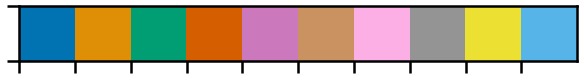

In [5]:
cmap = sns.color_palette('colorblind')
sns.palplot(cmap)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:75: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


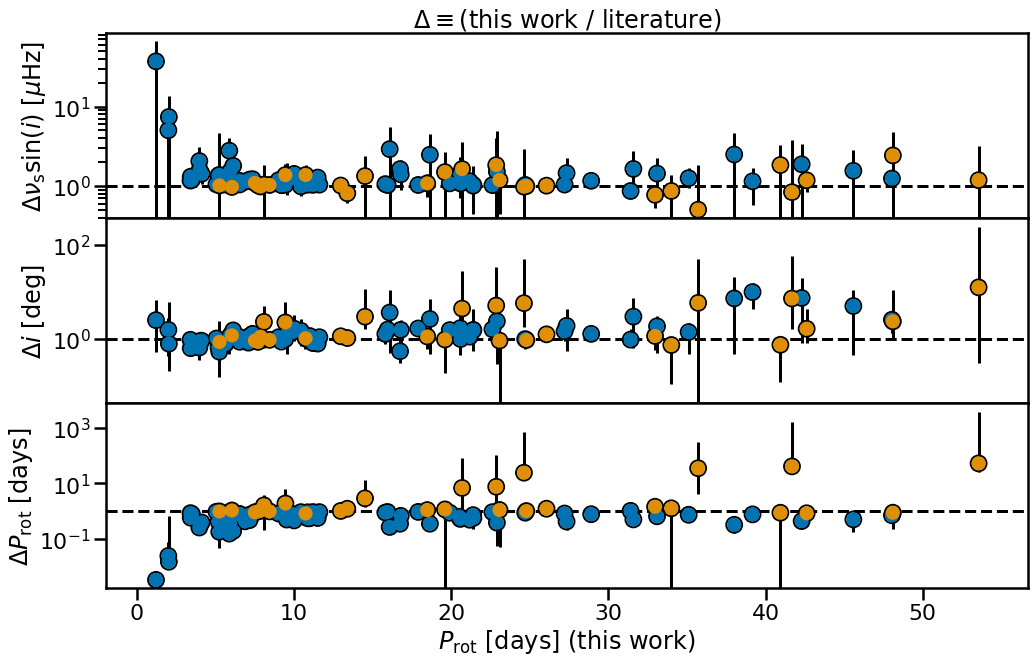

In [6]:
def e(a, siga, b, sigb):
    #return sigma for a/b
    rhs = (siga / b)**2 + (a*sigb/b**2)**2
    return np.sqrt(rhs)


size=200
col['x'] = np.ones(len(col)) * 60

fig, axes = plt.subplots(3, 1, figsize=mnras_size(2*595), sharex=True)

ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]

pk = ati['P'][ati.source == 'K']
pl = ati['P'][ati.source == 'L']

ak = ati['nus*'][ati.source == 'K']
ck = col['nus*'][ati.source == 'K']
al = ati['nus*'][ati.source == 'L']
cl = col['nus*'][ati.source == 'L']
upper = e(ati['nus*'], ati['u_nus*'], col['nus*'], col['u_nus*'])
lower = e(ati['nus*'], ati['l_nus*'], col['nus*'], col['l_nus*'])
ax0.scatter(pl, al/cl, s=size, ec='None', lw=1, zorder = 3, label='LEGACY')
ax0.scatter(pk, ak/ck, s=size, ec='None', lw=1, zorder = 3, label='Kages')

ax0.scatter(pk, ak/ck, s=size+50, ec='k', lw=2, fc='None', zorder = 2)
ax0.scatter(pl, al/cl, s=size+50, ec='k', lw=2, fc='None', zorder = 2)
ax0.axhline(1., ls='--', zorder=1, c='k')
ax0.errorbar(ati['P'], ati['nus*']/col['nus*'], yerr=[lower, upper],
             fmt='|', zorder=2, c='k')
ax0.set_ylabel(r'$\Delta\nu_{\rm s}\sin(i)$ [$\mu$Hz]')
ax0.set_yscale('log')
ax0.set_title(r'$\Delta \equiv$(this work / literature)')

ak = np.rad2deg(ati['i'][ati.source == 'K'])
ck = col['i'][ati.source == 'K']
al = np.rad2deg(ati['i'][ati.source == 'L'])
cl = col['i'][ati.source == 'L']
upper = e(np.rad2deg(ati['i']), np.rad2deg(ati['u_i']), col['i'], col['u_i'])
lower = e(np.rad2deg(ati['i']), np.rad2deg(ati['l_i']), col['i'], col['l_i'])
ax1.scatter(pl, al/cl, s=size, ec='None', lw=1, zorder = 3, label='L')
ax1.scatter(pk, ak/ck, s=size, ec='None', lw=1, zorder = 3, label='K')

ax1.scatter(pk, ak/ck, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='K')
ax1.scatter(pl, al/cl, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='L')
ax1.axhline(1., ls='--', zorder=1, c='k')
ax1.errorbar(ati['P'], np.rad2deg(ati['i'])/col['i'], yerr=[lower, upper],
             fmt='|', zorder=2, c='k')
ax1.set_ylabel(r'$\Delta i$ [deg]')
ax1.set_yscale('log')

ak = ati['P'][ati.source == 'K']
ck = col['P'][ati.source == 'K']
al = ati['P'][ati.source == 'L']
cl = col['P'][ati.source == 'L']
upper = e(ati['P'], ati['u_P'], col['P'], col['u_P'])
lower = e(ati['P'], ati['l_P'], col['P'], col['l_P'])
ax2.scatter(pl, al/cl, s=size, ec='None', lw=1, zorder = 3, label='L')
ax2.scatter(pk, ak/ck, s=size, ec='None', lw=1, zorder = 3, label='K')

ax2.scatter(pk, ak/ck, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='K')
ax2.scatter(pl, al/cl, s=size+50, ec='k', lw=2, fc='None', zorder = 2, label='L')
ax2.axhline(1., ls='--', zorder=1, c='k')
ax2.errorbar(ati['P'], ati['P']/col['P'], yerr=[lower, upper],
            fmt='|', zorder=2, c='k')
ax2.set_ylabel(r'$\Delta P_{\rm rot}$ [days]')
ax2.set_xlabel(r'$P_{\rm rot}$ [days] (this work)')

ax2.set_yscale('log')

plt.subplots_adjust(hspace=0)

from mpl_toolkits.axes_grid.inset_locator import inset_axes
col['Dnus*'] = ati['nus*'] / col['nus*']
col['Di'] = np.rad2deg(ati['i']) / col['i']
col['DP'] = ati['P'] / col['P']

# Violin 1
# iax0 = inset_axes(ax0, height ="100%", width="15%", loc=7)
# sns.violinplot(x='x', y='Dnus*', hue='label', 
#                inner='quartile',
#                data=col, palette=cmap, split=True, ax = iax0, legend=False)
# iax0.spines['right'].set_visible(False)
# iax0.spines['left'].set_visible(False)
# iax0.get_xaxis().set_visible(False)
# iax0.get_yaxis().set_visible(False)
# iax0.axhline(0, ls='--', c='k', zorder=0)
# iax0.legend_.remove()
# ax0.set_ylim(-1, 1.5)
# iax0.set_ylim(-1, 1.5)

# # Violin 2
# iax1 = inset_axes(ax1, height ="100%", width="15%", loc=7)
# sns.violinplot(x='x', y='Di', hue='label', data=col, 
#                 inner='quartile',
#                 palette=cmap, split=True, ax = iax1, legend=False)
# iax1.spines['right'].set_visible(False)
# iax1.spines['left'].set_visible(False)
# iax1.get_xaxis().set_visible(False)
# iax1.get_yaxis().set_visible(False)
# iax1.axhline(0, ls='--', c='k', zorder=0)
# iax1.legend_.remove()
# ax1.set_ylim(-70, 120)
# iax1.set_ylim(-70, 120)

# # Violin 2
# iax2 = inset_axes(ax2, height ="100%", width="15%", loc=7)
# sns.violinplot(x='x', y='DP', hue='label', data=col,
#                 inner='quartile',
#                 palette=cmap, split=True, ax = iax2, legend=False)
# iax2.spines['right'].set_visible(False)
# iax2.spines['left'].set_visible(False)
# iax2.get_xaxis().set_visible(False)
# iax2.get_yaxis().set_visible(False)
# iax2.axhline(0, ls='--', c='k', zorder=0)
# iax2.legend_.remove()
# ax2.set_xlim(0, 65)
# ax2.set_ylim(-100, 100)
# iax2.set_ylim(-100, 100)
# ax0.legend(ncol=2, loc='upper center')# bbox_to_anchor=[0.63,1.25,0.0,0.0])

# ax2.set_xticks(np.arange(0, 60, 5))

# plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/litcomp_alt.pdf', bbox_inches='tight', rasterized=True)

### Comparing to other published literature

In [7]:
lit = pd.read_csv('../data/literature_seismo.csv', index_col=0)
lit.head(2)

,KIC,C15_P_rot,C15_eP_rot,D16_P_rot,D16_u_eP_rot,D16_l_eP_rot,N15_P_rot,N15_u_eP_rot,N15_l_eP_rot,B18_P_rot,B18_l_eP_rot,B18_u_eP_rot
0,1435467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2837475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
len(np.isfinite(lit['D16_P_rot']))


94

In [9]:
ati.loc[np.isfinite(lit['D16_P_rot']).values]

,KIC,Teff,age,dnu,eTeff,ednu,efeh,enumax,feh,loage,...,eV2,l_P,P,u_P,l_vsini,vsini,u_vsini,rhat_flag,eye_flag,ebprp
62,12069424,5825,6.6735,103.277,50,0.021,0.03,4.6,0.10,0.7666,...,0.026682,1.114095,20.516716,1.975841,0.061279,2.112675,0.060261,rhat_1,2,0.001212
63,12069449,5750,7.3922,116.929,50,0.012,0.02,5.0,0.05,0.9103,...,0.025289,1.474881,21.178840,1.808344,0.062482,1.462994,0.063263,NaN,0,0.001060


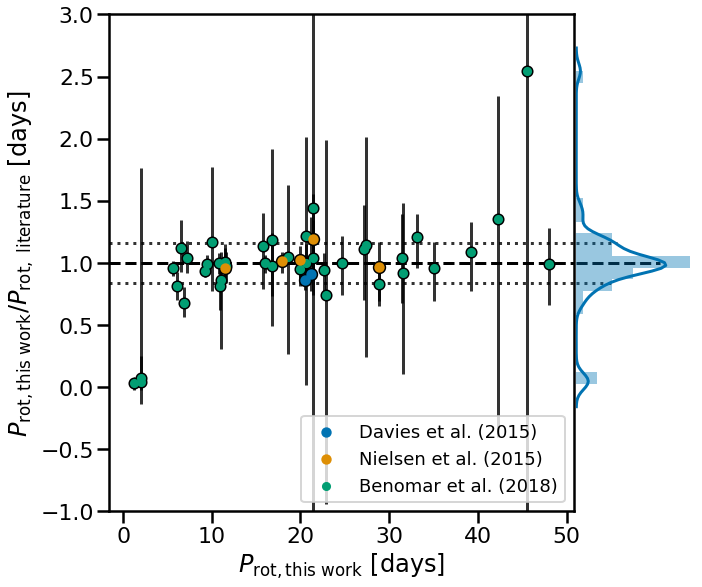

In [80]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

np.random.seed(11)

fig, ax = plt.subplots(figsize=mnras_size(595, square=True))

outA = (ati['P'] / lit['D16_P_rot']).dropna().values
upperA = e(ati['P'], ati['u_P'], lit['D16_P_rot'], lit['D16_u_eP_rot']).dropna().values
lowerA = e(ati['P'], ati['l_P'], lit['D16_P_rot'], lit['D16_l_eP_rot']).dropna().values
xA = np.random.uniform(0.5, 1.5, len(outA))
xA = ati['P'][np.isfinite(lit['D16_P_rot']).values]
ax.scatter(xA, outA, s=70, zorder=5, label='Davies et al. (2015)')
ax.errorbar(xA, outA, yerr = [lowerA, upperA], c='k', zorder=0, fmt='|', alpha=.8)

outB = (ati['P'] / lit['N15_P_rot']).dropna().values
upperB = e(ati['P'], ati['u_P'], lit['N15_P_rot'], lit['N15_u_eP_rot']).dropna().values
lowerB = e(ati['P'], ati['l_P'], lit['N15_P_rot'], lit['N15_l_eP_rot']).dropna().values
xB = np.random.uniform(0.6, 1.4, len(outB)) + 0.3
xB = ati['P'][np.isfinite(lit['N15_P_rot']).values]
ax.scatter(xB, outB, s=70, zorder=4, label='Nielsen et al. (2015)')
ax.errorbar(xB, outB, yerr = [lowerB, upperB], c='k', zorder=0, fmt='|', alpha=.8)

outD = (ati['P'] / lit['B18_P_rot']).dropna().values
upperD = e(ati['P'], ati['u_P'], lit['B18_P_rot'], lit['B18_u_eP_rot']).dropna().values
lowerD = e(ati['P'], ati['l_P'], lit['B18_P_rot'], lit['B18_l_eP_rot']).dropna().values
xD = np.random.uniform(0.3, 1.8, len(outD)) + 1.3
xD = ati['P'][np.isfinite(lit['B18_P_rot']).values]
ax.scatter(xD, outD, s=50, zorder=2, label='Benomar et al. (2018)')
ax.errorbar(xD, outD, yerr = [lowerD, upperD], c='k', zorder=0, fmt='|', alpha=.8)

ax.scatter(xA, outA, s=70, ec='k', lw=5, fc=None)
ax.scatter(xB, outB, s=70, ec='k', lw=5, fc=None)
ax.scatter(xD, outD, s=50, ec='k', lw=5, fc=None)

ax.axhline(1., ls='--', c='k', zorder=0, lw=3)
ax.set_ylim(-1, 3)
ax.set_ylabel(r'$P_{\rm{rot, this\ work}} / P_{\rm rot,\ literature}$ [days]')
ax.set_xlabel(r'$P_{\rm{rot, this\ work}}$ [days]')

ax.legend(loc='lower right', fontsize=18)
fig.tight_layout()

left, bottom, width, height = [.9745, .133, 0.2, .8345]
iax = fig.add_axes([left, bottom, width, height])

sns.distplot(np.concatenate([outA, outB, outD]), ax=iax, vertical=True)
iax.set_ylim(-1, 3)
iax.spines['right'].set_visible(False)
iax.spines['left'].set_visible(False)
iax.spines['top'].set_visible(False)
iax.spines['bottom'].set_visible(False)
iax.get_xaxis().set_visible(False)
iax.get_yaxis().set_visible(False)
iax.axhline(1., ls='--', c='k', zorder=0, lw=3, xmax=0.7)
p = np.percentile(np.concatenate([outA, outB, outD]),[15.9, 84.1])
iax.axhline(p[0], c='k', ls=':', alpha=.8, zorder=0, lw=3, xmax=0.33)
iax.axhline(p[1], c='k', ls=':', alpha=.8, zorder=0, lw=3, xmax=0.34)

ax.axhline(p[0], c='k', ls=':', alpha=.8, zorder=0, lw=3)
ax.axhline(p[1], c='k', ls=':', alpha=.8, zorder=0, lw=3)

plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/seis_comparison_rot_alt.pdf', rasterized=True)
plt.savefig('/Users/Oliver/Dropbox/Apps/Overleaf/Malatium/Images/seis_comparison_rot_alt.png', dpi=300)